In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
nrow = 150
ncol = 150

train_data_dir = './train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=1000,
                        class_mode='sparse')

test_data_dir = './test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=300,
                        class_mode='sparse')

# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

Found 3000 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [15]:
ytr.shape

(1000,)

(1000,)

In [13]:
Xtr, ytr = train_generator.next()
Xts, yts = test_generator.next()
Xtr_gray = np.dot(Xtr,[0.299,0.587,0.114]).reshape((1000,nrow*ncol))
Xts_gray = np.dot(Xts,[0.299,0.587,0.114]).reshape((300,nrow*ncol))

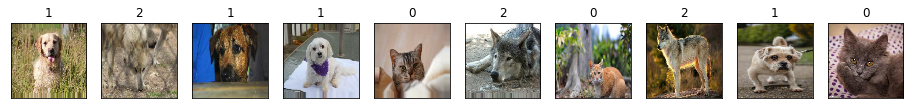

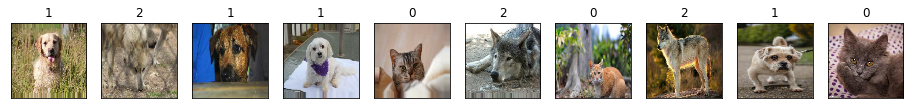

In [16]:
plt.figure(figsize=(16,16))
for i in range(10):   
    plt.subplot(1,10,i+1)
    disp_image(Xtr[i])
    plt.title(int(ytr[i]))

# SVM

In [ ]:
from sklearn import svm

Xtr_s = Xtr.reshape((1000,nrow*ncol*3))
Xts_s = Xts.reshape((300,nrow*ncol*3))

C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

# Measure and print the accuracy for each C and gamma value.  Store the results in acc
for i in range(nC):
    for j in range(ngam):
        svc = svm.SVC(kernel='rbf',C=C_test[i],gamma=gam_test[j])
        svc.fit(Xtr_s,ytr)
        yhat_ts = svc.predict(Xts_s)
        acc[i][j] = np.mean(yhat_ts == yts)
        
# Print the maximum accuracy and the corresponding best C and gamma
C_best = C_test[np.where(acc==np.max(acc))[0][0]]
gam_best = gam_test[np.where(acc==np.max(acc))[1][0]]
print('The maximum accuracy is',np.max(acc))
print('The corresponding best C and gamma are',C_best,'and',gam_best)

# PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
scaler.fit(Xtr_gray)
Xtr_scl = scaler.transform(Xtr_gray)

pca = PCA(n_components=0.95,svd_solver='full')
pca.fit(Xtr_scl)
Ztr = pca.transform(Xtr_scl)

logreg = LogisticRegression(multi_class='auto',solver='newton-cg')
logreg.fit(Ztr,ytr)

Xts_scl = scaler.transform(Xts_gray)
Zts = pca.transform(Xts_scl)
yhat = logreg.predict(Zts)

acc = np.mean(yhat==yts)
acc

# CNN

In [ ]:
from tensorflow.python.client import device_lib
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
import keras.backend as K

print(device_lib.list_local_devices())
K.clear_session()

In [ ]:
# Load the VGG16 network
input_shape = (nrow,ncol,3)
base_model = applications.VGG16(weights='imagenet',input_shape=input_shape,include_top=False)

# Create a new model
model = Sequential()

# Loop over base_model.layers and add each layer to model
for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False
    
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='softmax'))
model.summary()

In [ ]:
test_generator.n.type

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

# Number of epochs
nepochs = 5

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // 1000,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=test_generator.n // 300)

In [ ]:
# Plot the training accuracy and validation accuracy curves on the same figure.
tr_acc = hist.history['acc']
val_acc = hist.history['val_acc']
plt.plot(np.arange(nepochs)+1,tr_acc,label='training accuracy')
plt.plot(np.arange(nepochs)+1,val_acc,label='validation accuracy')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
Xts_err = []
yts_err = []
z_err = []
n = 0

while (n<4):
    Xts ,yts = test_generator.next()
    z = model.predict(Xts).reshape(yts.shape)
    yhat = np.array(z>0.5,dtype=int)
    ierr = np.where(yts != yhat)[0]
    n = n + len(ierr)
    for i in ierr:
        Xts_err.append(Xts[i])
        yts_err.append(yts[i])
        z_err.append(z[i])
    
plt.figure(figsize=(20,20))
for i in range(n):   
    plt.subplot(n//3,3,i+1)
    disp_image(Xts_err[i])
    if int(yts_err[i]) == 0:
        plt.title('true label = bicycle, class probability={0:f}'.format(z_err[i]))
    else:
        plt.title('true label = car, class probability={0:f}'.format(z_err[i]))